## UPSC Essay Evaluation AI

These essays will get evaluated based on following:\
    - Clarity of Thoughts\
    - Depth of Analysis\
    - Language
    

In return will get **Text Feedback along with score**

Then collective feedback will get passed to `Final Evaluation` node. Here after collecting feedback, sumarizy along with score will be generated.

In [12]:
# Authenticate user for Google Cloud (Vertex AI) access
from google.colab import userdata
from google.colab import auth
auth.authenticate_user()
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')
GOOGLE_CLOUD_PROJECT=userdata.get('GOOGLE_CLOUD_PROJECT')


# Importing libraries :
from langgraph.graph import StateGraph, START, END
# !pip3 install langchain_google_genai --quiet --exists-action i --no-input
# !pip3 install langchain --quiet --exists-action i --no-input
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [13]:
# creating a model
model = ChatGoogleGenerativeAI(
    model="gemini-3-pro-preview",
    project=GOOGLE_CLOUD_PROJECT,
    location="global",
    temperature=1.0,
)

In [14]:
class EvaluateSchema(BaseModel):
    feedback : str = Field(description="Detailed feedback for the eassay")
    score : int = Field(description="Score out of 10 for the eassay", ge=0, le=10)

In [15]:
structured_model = model.with_structured_output(EvaluateSchema)

In [16]:
essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [17]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"

structured_model.invoke(prompt)
# structured_model.invoke(prompt).feedback # extract feedback
# structured_model.invoke(prompt).score # extract score

EvaluateSchema(feedback="The essay demonstrates excellent language quality with a sophisticated command of vocabulary and grammar. The structure is logical and coherent, seamlessly transitioning from an introduction of the context to India's strengths, specific applications of AI, challenges, and strategic recommendations. The author effectively uses transition words to guide the reader through the arguments. The vocabulary is rich and precise, utilizing terms such as 'burgeoning,' 'interoperability,' and 'demographic dividend' correctly. There are no noticeable grammatical, spelling, or punctuation errors. The tone is consistently formal and analytical, fitting for the subject matter. While the essay is structurally sound and linguistically polished, adding specific recent statistics or concrete case studies could further strengthen the substantive arguments.", score=9)

In [18]:
class UPSCState(TypedDict):
    eassay : str
    language_feedback : str
    analysis_feedback : str
    clarity_feedback :  str
    overall_feedback : str
    # now we need to store `individual_scores` for defiled 3 nodes like {evaluate_language, evaluate_analysis, evaluate_thoughts}
    # since this is parallel workflow it will ended up with error if we use as it it, we have to use reducer function; here that is `add`
    individual_scores : Annotated[list[int], operator.add]
    avg_score : float

In [19]:
def evaluate_language(state: UPSCState) -> UPSCState:
    """
    here we've pass essay to Structured Model
    and would like to collect feedback and score based on language
    """
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['eassay']}"

    # now lets call structured_model with the above prompt
    output = structured_model.invoke(prompt)
    return {
        'language_feedback' : output.feedback,
        'individual_scores' : [output.score]
        }

In [20]:
def evaluate_analysis(state: UPSCState) -> UPSCState:
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['eassay']}"

    # now lets call structured_model with the above prompt
    output = structured_model.invoke(prompt)
    return {
        'analysis_feedback' : output.feedback,
        'individual_scores' : [output.score]
        }

In [21]:
def evaluate_thoughts(state: UPSCState) -> UPSCState:
    prompt = f"Evaluate the clarity of thoughts the following essay and provide a feedback and assign a score out of 10 \n {state['eassay']}"

    # now lets call structured_model with the above prompt
    output = structured_model.invoke(prompt)
    return {
        'clarity_feedback' : output.feedback,
        'individual_scores' : [output.score]
        }

In [22]:
def final_evaluation(state: UPSCState) -> UPSCState:
    # it will generate summary feedback
    prompt = f'Based on depth of analysis on the following feedbacks create a summarized feedback on language feedback - {state["language_feedback"]}\n depth of analysis feedback - {state["analysis_feedback"]}\n clarity of thought feedback - {state["clarity_feedback"]}'

    overall_feedback = model.invoke(prompt).content

    # also average will be calculated of all score
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback':overall_feedback, 'avg_score':avg_score}

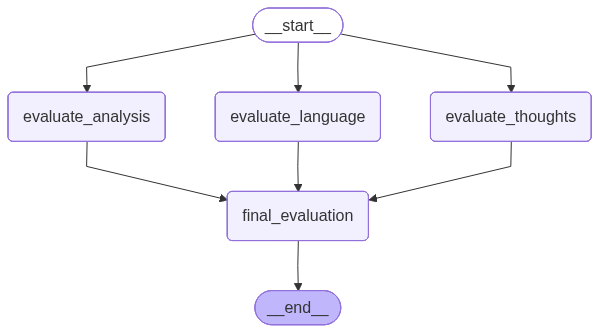

In [24]:
# graph
graph = StateGraph(UPSCState)

# nodes
graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thoughts',evaluate_thoughts)
graph.add_node('final_evaluation',final_evaluation)

# edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thoughts')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thoughts','final_evaluation')

graph.add_edge('final_evaluation',END)

workflow = graph.compile()
workflow

In [25]:
initial_state = {
    'eassay' : essay
    # 'individual_scores' : []
}

workflow.invoke(initial_state)

{'eassay': "India in the Age of AI\nAs the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.\n\nIndia's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for